In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations
using GaussianProcess

discourse.julialang.org/t/is-there-a-turing-alternative-to-pm-deterministic-from-pymc3/38667

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html

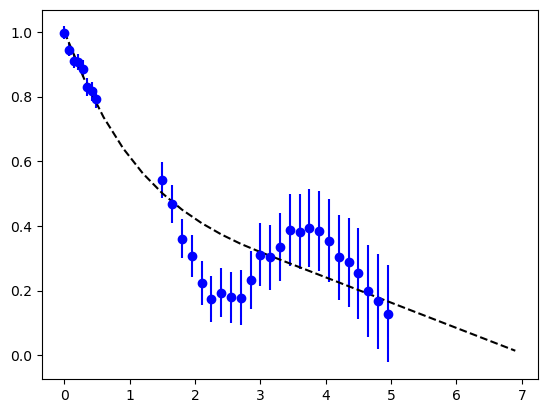

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3a511b3220>

In [7]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5)
data_2_x = Vector(1.5:0.15:5)
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = zeros(24,1)
gp_x[:, 1] = Vector(0:0.3:7)
gp_N = length(vec(gp_x))
plt.plot(vec(gp_x), cosmology.Dz(vec(gp_x)) .* ones(gp_N), "k--")

In [8]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [18]:
function model_latent_GP(eta, l, v; 
                         X=gp_x, data_cov=nonlin_data_cov, cosmology=Cosmology())
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(X, eta, l)
    mean = cosmology.Dz(vec(X))
    gp = latent_GP(mean, v, kernel)
    y = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    return gp, y
end

model_latent_GP (generic function with 1 method)

In [19]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
for i in 1:N_samples
    eta = rand(Exponential(1))
    l = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(gp_N), ones(gp_N)))
    gps[i, :], ys[i, :] = model_latent_GP(eta, l, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

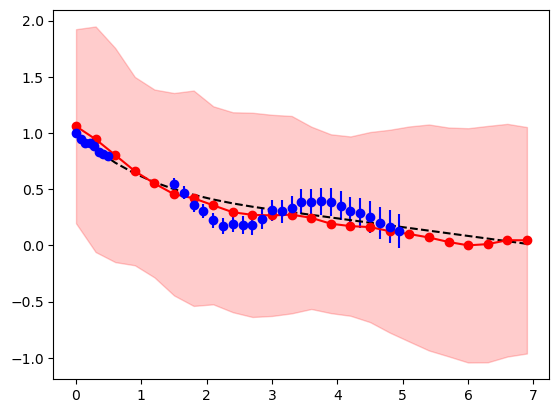

PyObject <matplotlib.collections.PolyCollection object at 0x7f3a51035fd0>

In [20]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), cosmology.Dz(vec(gp_x)), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "ro-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")

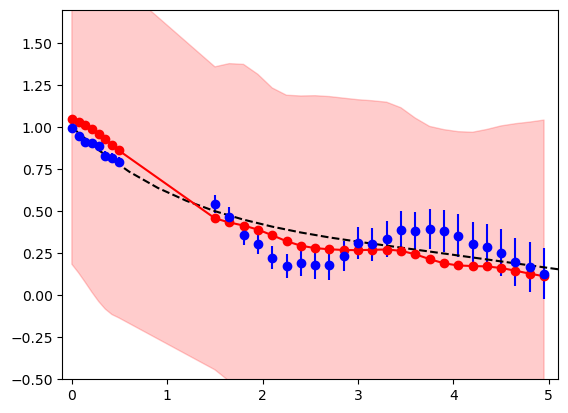

(-0.5, 1.7)

In [21]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), cosmology.Dz(vec(gp_x)), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "ro-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")
plt.xlim(-0.1, 5.1)
plt.ylim(-0.5, 1.7)

In [23]:
@model function latent_GPP(y, X; data_x=data_x, data_cov=data_cov, cosmology=Cosmology())
    # Priors.
    eta ~ Exponential(1)
    l ~ Uniform(0.1, 3)
    v ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta, l)
    mean = cosmology.Dz(vec(X))
    gp = latent_GP(mean, v, kernel)
    m = conditional(X, data_x, gp, sqexp_cov_fn; eta=eta, l=l)
    y ~ MvNormal(m, data_cov)
end

latent_GPP (generic function with 1 method)

In [24]:
chain = sample(latent_GPP(data, gp_x), HMC(0.005, 100), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:04:39


Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = eta, l, v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

         eta    0.1224    0.1728     0.0055    0.0281    41.2495    1.0392
           l    1.1500    0.7913     0.0250    0.2257     5.6298    1.1686
        v[1]    0.0683    0.3501     0.0111    0.0241   438.4392    1.0000
        v[2]   -0.1408    0.6418     0.0203    0.0808    32.1491    1.0502
        v[3]    0.2041    0.9297     0.0294    0.1578    27.9044    1.

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [25]:
eta_p = group(chain, :eta).value.data[:, :, 1]
l_p = group(chain, :l).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1]

1000×24 Matrix{Float64}:
  6.69282     -8.06056    -9.33719   …   1.2058      0.563655    0.0690263
  6.92594     -3.88628    -4.97063       1.20525    -0.0339779  -0.437261
 -0.856103    -1.08538    -1.60737       0.367979    0.83299     0.707079
  1.66649      5.30051     3.23711      -0.322273    0.598131    0.910007
 -1.58831      2.80412    -0.349954     -0.231472    0.774764    1.27506
 -1.25943      2.65098    -0.778446  …  -0.0802032   0.209055    1.37201
  1.08386      3.11456    -0.712381     -0.603179    0.483558    0.609869
 -0.433048     1.91103    -1.36597      -1.03694    -0.0835392   0.295618
 -0.74051      1.90983    -1.37755      -0.34336     0.350771    0.565777
  0.93819      0.809023   -0.950732      0.635528   -0.0772311  -0.45682
 -0.0671115    0.891303   -1.1705    …   0.2328      0.543377   -0.84715
  0.0934025    0.493579   -1.06534      -0.205866    0.351898   -0.743243
  0.428805     0.734004   -1.54512      -0.489391    0.995907   -0.430371
  ⋮             

In [26]:
N_samples = length(eta_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
for i in 1:N_samples
    gps[i, :], ys[i, :]  = model_latent_GP(eta_p[i], l_p[i], v_p[i, :])
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

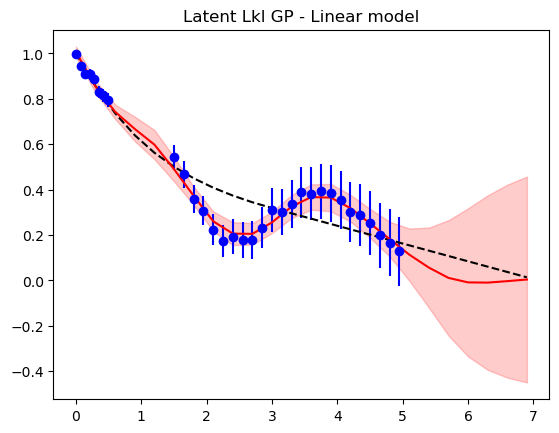

PyObject Text(0.5, 1.0, 'Latent Lkl GP - Linear model')

In [27]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), cosmology.Dz(vec(gp_x)), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")
plt.title("Latent Lkl GP - Linear model")

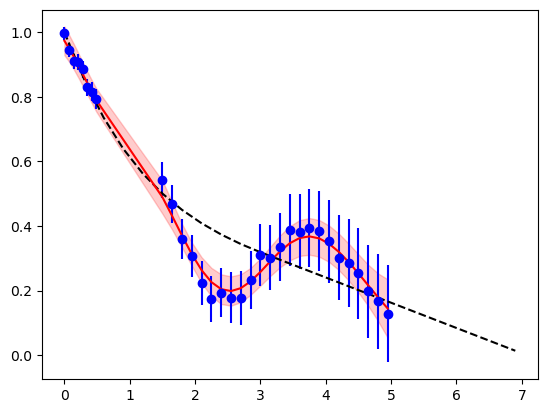

PyObject <matplotlib.collections.PolyCollection object at 0x7f3a5c656c40>

In [28]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), cosmology.Dz(vec(gp_x)), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "r-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")